In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

sequence_length = 2
training_start = '2018-01-01'
training_end = '2019-12-31' 

# load the training data
training = pd.read_parquet('data/training.parquet')
lats = training['lat'].unique()
features = []
targets = []
for lat in lats[0:4]:
    # slice the data by latitude
    this = training[training['lat'] == lat]
    start_index = this[this['time'] == training_start].index.values[0]
    end_index = this[this['time'] == training_end].index.values[0]
    for i in range(start_index,end_index):
        feature_vec = this['ndvi_smoothed'][i:i+sequence_length].values
        target = this['ndvi_smoothed'][i+sequence_length]
        # convert feature_vec to a tensor
        feature_vec = torch.tensor(feature_vec, dtype=torch.float32)
        # convert target to a tensor
        target = torch.tensor(target, dtype=torch.float32)
        features.append(feature_vec)
        targets.append(target)



features = torch.stack(features)
features = features.unsqueeze(-1)
targets = torch.stack(targets)
targets = targets.unsqueeze(-1)

features.shape, targets.shape

(torch.Size([2952, 2, 1]), torch.Size([2952, 1]))

In [73]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MyModel, self).__init__()
        self.f = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.f(x)
        out = self.fc(out[:, -1, :])
        return out

num_epochs = 2000
input_size = 1
hidden_size = 8  # 16
num_layers = 1
model = MyModel(input_size, hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
print("Training...")
for epoch in range(num_epochs):
    outputs = model(features)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Training...
Epoch [100/2000], Loss: 0.0852
Epoch [200/2000], Loss: 0.0506
Epoch [300/2000], Loss: 0.0373
Epoch [400/2000], Loss: 0.0244
Epoch [500/2000], Loss: 0.0121
Epoch [600/2000], Loss: 0.0034
Epoch [700/2000], Loss: 0.0006
Epoch [800/2000], Loss: 0.0003
Epoch [900/2000], Loss: 0.0003
Epoch [1000/2000], Loss: 0.0003
Epoch [1100/2000], Loss: 0.0003
Epoch [1200/2000], Loss: 0.0003
Epoch [1300/2000], Loss: 0.0003
Epoch [1400/2000], Loss: 0.0002
Epoch [1500/2000], Loss: 0.0002
Epoch [1600/2000], Loss: 0.0002
Epoch [1700/2000], Loss: 0.0002
Epoch [1800/2000], Loss: 0.0002
Epoch [1900/2000], Loss: 0.0002
Epoch [2000/2000], Loss: 0.0002


In [74]:
# save the model weights to disk
torch.save(model.state_dict(), 'model_weights.pth')
# model.load_state_dict(torch.load('model_weights.pth'))

In [75]:
import matplotlib.pyplot as plt

def predict(recent_history):
    # recent_history is a list of floats
    # convert recent_history to a tensor
    recent_history = torch.tensor(recent_history, dtype=torch.float32)
    # add a batch dimension
    recent_history = recent_history.unsqueeze(0)
    # add a feature dimension
    recent_history = recent_history.unsqueeze(-1)
    # predict
    prediction = model(recent_history)
    # convert prediction to a float
    prediction = prediction.item()
    return prediction

# load s2l8.parquet
s2l8 = pd.read_parquet('data/s2l8.parquet')
where = 6
pure = s2l8[s2l8['lat'] == lats[where]]
this = training[training['lat'] == lats[where]]
start_date = '2019-01-01'
end_date = '2019-12-31'

ds = this.loc[this['time'] == start_date].index 
de = this.loc[this['time'] == end_date].index  
fs = ds - sequence_length
ds = ds.values[0]
fs = fs.values[0]
de = de.values[0]

nn = this[ds:]
nn = nn[nn['time'] <= end_date]
nn = nn.drop(['lat','ndvi','ndvi_smoothed'], axis=1)
current_feature = this['ndvi_smoothed'][fs:fs+sequence_length].values
for i in range(ds,de+1):
    # get the ith row of this
    row = this.iloc[i]
    date = row['time']
    # check if this date exists in s2l8
    if date in pure['time'].values:
        # we have a real measurement
        x = {'time':date, 'ndvi_smoothed':row['ndvi_smoothed']}
        # pd.concatenate nn and x
        nn = pd.concat([nn, pd.DataFrame(x, index=[0])], ignore_index=True)
        current_feature = this['ndvi_smoothed'][i-sequence_length+1:i+1].values
    else:
        # we need to predict
        prediction = predict(current_feature)
        # add prediction to nn
        x = {'time':date, 'ndvi_smoothed':prediction}
        nn = pd.concat([nn, pd.DataFrame(x, index=[0])], ignore_index=True)
        # update current_feature
        current_feature = np.append(current_feature[1:], prediction)


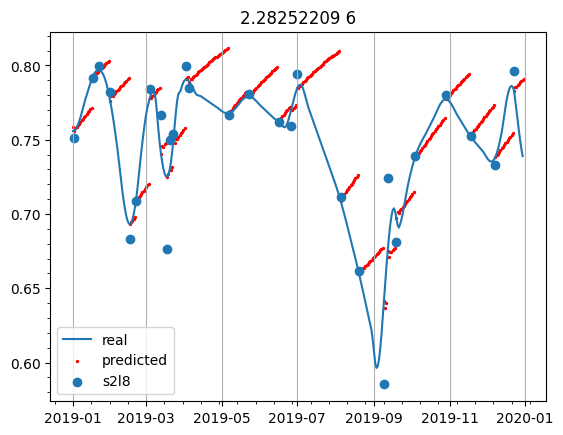

In [76]:
this1 = this[ds:de]
pure1 = pure[(pure['time'] >= start_date) & (pure['time'] <= end_date)]
plt.title(str(lats[where]) + ' ' + str(where))
# plot this['ndvi_smoothed'] and nn['ndvi_smoothed'] with legends vs time
plt.plot(this1['time'], this1['ndvi_smoothed'], label='real')
plt.scatter(nn['time'], nn['ndvi_smoothed'], label='predicted',s=2,color='red')
# plots s2l8['ndvi'] vs time
plt.scatter(pure1['time'], pure1['ndvi'], label='s2l8')
# add vertical grid lines
plt.grid(axis='x')
# add minor vertical grid lines
plt.minorticks_on()


plt.legend()
plt.show()




